# Makermore Part 5 - Wavenet

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [5]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> m
......em --> m
.....emm --> a
....emma --> .
........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .
........ --> a
.......a --> v
......av --> a
.....ava --> .
........ --> i
.......i --> s
......is --> a
.....isa --> b


In [19]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  def __init__(self, fan_in, fan_out, generator = torch.Generator().manual_seed(2147483647), bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator = generator) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
      
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim, g):
    self.weight = torch.rand((num_embeddings, embedding_dim),generator=g)
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []
  
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []


# -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [35]:
g = torch.manual_seed(2147483647)
n_embd = 2 # the dimensionality of the character embedding vectors
n_hidden = 5 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd, g),
  FlattenConsecutive(2), 
  # Linear(n_embd * 2, n_hidden, generator=g, bias=False), 
  # BatchNorm1d(n_hidden), Tanh(),
  # FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, generator=g, bias=False), BatchNorm1d(n_hidden), Tanh(),
  # FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, generator=g, bias=False), 
  # BatchNorm1d(n_hidden), 
  # Tanh(),
  # Linear(n_hidden, vocab_size),
])

# parameter init
# with torch.no_grad():
#   model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  
# logits = torch.zeros(7, 27)
# for i in range(7):
#   logits[i] = model(Xtr[[5+i]])

x = model(Xtr[[9]])
x

54


tensor([[[0.7081, 0.3542, 0.7081, 0.3542],
         [0.7081, 0.3542, 0.7081, 0.3542],
         [0.5998, 0.1621, 0.9928, 0.3419],
         [0.9600, 0.4388, 0.6008, 0.1163]]], grad_fn=<ViewBackward0>)

In [ ]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] 
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) 
  
  for p in parameters:
    p.grad = None
  loss.backward()
  
  lr = 0.1 if i < 150000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0: 
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 100000: 3.2890


NameError: name 'die' is not defined

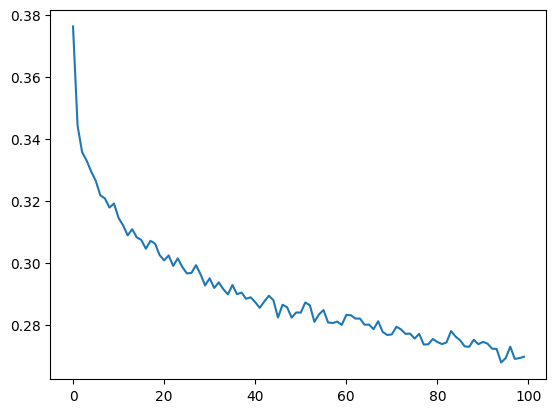

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8586403131484985
val 2.2829551696777344


In [ ]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

sudreeno.
leiton.
dani.
kenigaa.
keylah.
milayana.
evera.
juday.
mia.
rosann.
nuria.
kholana.
meyoreth.
mahlily.
zykeli.
jenesia.
katalynn.
lashlin.
damarr.
azyia.


In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = True

In [15]:
for x, y in zip(Xtr[5:12], Ytr[5:12]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .


In [ ]:
logits = torch.zeros(7, 27)
for i in range(7):
  logits[i] = model(Xtr[[7+i]])

In [53]:
import torch
import torch.nn as nn

class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(WaveNetBlock, self).__init__()
        self.conv_dilated = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, padding=(kernel_size - 1) * dilation // 2)
        self.conv_residual = nn.Conv1d(out_channels, out_channels, 1)
        self.conv_skip = nn.Conv1d(out_channels, out_channels, 1)

    def forward(self, x):
        output = torch.tanh(self.conv_dilated(x))
        residual = self.conv_residual(output)
        skip = self.conv_skip(output)
        return (skip, residual + x)

class WaveNet(nn.Module):
    def __init__(self, num_layers, num_blocks, num_channels, kernel_size):
        super(WaveNet, self).__init__()
        self.num_layers = num_layers
        self.num_blocks = num_blocks
        self.num_channels = num_channels
        self.kernel_size = kernel_size

        # Stack multiple WaveNet blocks
        self.blocks = nn.ModuleList([
            WaveNetBlock(num_channels, num_channels, kernel_size, 2 ** i) for _ in range(num_blocks) for i in range(num_layers)
        ])

        # Additional layers for output
        self.output_conv1 = nn.Conv1d(num_channels, num_channels, 1)
        self.output_conv2 = nn.Conv1d(num_channels, 1, 1)

    def forward(self, x):
        skips = []
        for block in self.blocks:
            skip, x = block(x)
            skips.append(skip)

        # x = torch.sum(torch.stack(skips), dim=0)
        # x = torch.relu(self.output_conv1(x))
        # x = self.output_conv2(x)
        return x

# Example usage:
num_layers = 10
num_blocks = 1
num_channels = 64
kernel_size = 2
input_length = 1000  # Example input length
batch_size = 1

# Create a random input signal
input_signal = torch.randn(batch_size, 1, input_length)

# Create an instance of WaveNet
model = WaveNet(num_layers, num_blocks, num_channels, kernel_size)
# Forward pass
output = model(input_signal)
print("Output shape:", output.shape)


RuntimeError: Given groups=1, weight of size [64, 64, 2], expected input[1, 1, 1000] to have 64 channels, but got 1 channels instead